<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#006400'> 
    
# 1. Intro </font>
</a>

Import Libraries, Data and define Cluster scenarios.
    
</div>

In [38]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import KNNImputer 
from sklearn.cluster import KMeans
import scipy  
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score

In [23]:
# Read Data
df = pd.read_csv("df_preprocessed.csv")

In [24]:
# Set "Customer ID" as an index
df.set_index('Customer ID', inplace = True)

## `MetaData`
- __CustomerID__: A unique ID that identifies each customer

__`DEMOGRAPHICS:`__
- __Age__: Customer's current age in years
- __Under 30__: A flag indicating if customer is under 30 (1) or above (0)
- __Senior Citizen__: A flag indicating if customer is 65 or older (1) or not (0)
- __Gender_Male__: A flag indicating if customer is male (1) or female (0)
- __Dependents__: A flag indicating if customer has dependents (1) or not (0)
- __Number of Dependents__: Indicates number of dependents living with the customer
- __Married__: A flag indicating if customer is married (1) or not (0)

__`LOCATION & POPULATION DATA:`__ Country: US; State: California
- __City__: The city of the customer's primary residence
- __Zip Code__: 
- __Lat Long__: The combined latitude and longitude of the customer's primary residence
- __Latitude__: The latitude of the customer's primary residence
- __Longitude__: The longitude of the customer's primary residence
- __Population__: A current population estimate for the entire Zip Code area
- __Density_High__: A flag indicating if the area the customer lives has high population density 
- __Density_Low__: A flag indicating if the area the customer lives has low population density
- If both are zero, then density is medium

__`SERVICES:`__
- __Phone Service__: subscribes to home phone service (1) or not 
- __Internet Service__: subscribes to internet servie (1) or not 
- __Online Security__: subscribes to an additional online security service (1) or not 
- __Online Backup__: subscribes to an additional online backup service (1) or not 
- __Multiple Lines__: subscribes to multiple telephone lines with the company (1) or not 
- __Device Protection Plan__: subscribes to an additional device protection plan for their internet equipment (1) or not 
- __Premium Tech Support__: subscribes to an additional technical support plan with reduced wait times (1) or not 
- __Unlimited Data__: paid an additional monthly fee to have unlimited data downloads/uploads (1) or not 
- __Internet Type_Cable__: subscribes with internet cable (1) or not 
- __Internet Type_DSL__: subscribes with DSL (1) or not 
- __Internet Type_Fiber Optic__: subscribles with DSL (1) or not 

__`STREAMING:`__ No fee associated, is if uses the internet service to stream services from a third provider
- __Streaming TV__: uses streaming for TV programing
- __Streaming Movies__: uses streaming for movies
- __Streaming Music__: uses streaming for music

__`TENURE & CONTRACT:`__
- __Tenure in Months__: Total amount of months that the customer has been with the company
- __Tenure Category__: 0 if customer joined this quarter, 1 if joined > 3 - 18 m, 2 if joined > 18 - 36 m, 3 if joined > 36 - 54 m, 4 if joined  54 - 72 m
- __Contract__: -"month-to-month" is 1, "one year" is 2, "two year" is 3

__`PAYMENT PREFERENCES:`__
- __Paperless Billing__: has chosen paperless billing (1) or not (0)
- __Payment Method_Bank Withdrawal__: pays their bill with bank withdrawl (1) or not (0)
- __Payment Method_Credit Card__: pays their bill with credit card (1) or not (0)
- If both are zero then it pays with mailed check

__`REFERRALS AND OFFERS:`__
- __Referred a Friend__:
- __Number of Referrals__:
- __Offer_Offer A, Offer_Offer B, Offer_Offer C, Offer_Offer D, Offer_Offer E__: A flag indicating the last marketing offer the customer accepted (1) or not (0)

__`PROFITABILITY:`__
- __Total Revenue__: Total Charges + Extra Data Charges + Long Distance Charges - Refunds
- __Total Charges__: Customer's total charges at the end of the quarter
- __Total Refunds__: Customer's total refunds at the end of the quarter
- __Monthly Charge__: Customer's current total monthly charge for all their services from the company
- __Total Extra Data Charges__: Charges for extra data downloads above those specified in their plan
- __Total Long Distance Charges__: Charges for long distance above those specified in their plan
- __Avg Monthly Long Distance Charges__: Average long distance charges 

__`STATUS:`__
- __New Customer__: Is a new customer, i.e. joined this quarter (1) or not (0)
- __Churn Label__: 1 if the customer left the company this quarter or 0 if remained
- __Churn Score__: A value from 0-100 calculated using the predictive tool IBM SPSS Modeler, incorporating factors known to cause churn. The higher, the more likely the customer will churn
- __Churn Category_Attitude, Churn Category_Competitor, Churn Category_Dissatisfaction, Churn Category_Price__: Churn category's flag (1)
- __Churn Reason__: A customer's specific reason for leaving the company. Directly related to Churn Category but more descriptive
- __Satisfaction Score__: A customer's overall satisfaction rating of the company from 1 (very unsatisfied) to 5 (very satisfied)
- __Engagement Score__: Calculated score based on the number of services a customer has subscribed to. The more services, it adds up +1. Varies between 1 and 7
- __CLTV__: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#006400'> 
    
# 2. Cluster pre-defined Functions</font>
</a>
    
</div>

In [25]:
# Define a function to perform elbow method and dendrogram side by side

def plot_clustering_methods(df, k_range):
    def elbow_method(df, k_range, ax):
        ks = range(1, k_range + 1)
        inertias = []
        for k in ks:
            model = KMeans(n_clusters=k).fit(df)
            inertias.append(model.inertia_)

        #calculate the derivative of the inertias values
        dd = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
        # find the second max and min values in the dd array
        second_max = np.partition(dd, -2)[-2]
        second_min = np.partition(dd, 1)[1]
        # find the indices of the second max and min values in the dd array
        second_max_idx = np.where(dd == second_max)[0][0]
        second_min_idx = np.where(dd == second_min)[0][0]
        # obtain the line equation for the derivative y - y1 = m * (x - x1) with m being the second max or min(dd)
        y1 = [(x-second_max_idx)*second_max + inertias[second_max_idx] for x in range(len(ks))]
        y2 = [(x-second_min_idx)*second_min + inertias[second_min_idx] for x in range(len(ks))]

        ax.plot(ks, inertias)
        ax.plot(ks, y1, 'r--')
        ax.plot(ks, y2, 'r--')
        ax.set_ylim(0, None)
        ax.set_xlabel('number of clusters')
        ax.set_ylabel('inertia')
        ax.set_xticks(ks)
        ax.set_title('Elbow Method')

    def dendrogram_method(df, ax):
        df_sample = df.sample(n=1000, random_state=100)
        clusters = hierarchy.linkage(df_sample, method="ward")
        hierarchy.dendrogram(clusters, ax=ax)
        ax.set_title('Dendrogram')

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Call the functions with the appropriate axes
    elbow_method(df, k_range, ax1)
    dendrogram_method(df, ax2)

    # Display the plots
    plt.show()

# Example usage:
# plot_clustering_methods(df, k_range=10)

In [26]:
# Define a function to perform KMeans clustering

def fit_kmeans_centroids(df, n_clusters, random_state=100):
    df_copy = df.copy()
    model = KMeans(n_clusters=n_clusters, random_state=random_state).fit(df_copy)
    df_copy['label'] = model.labels_
    df["label"] = model.labels_
    centroids = df_copy.groupby(['label']).mean().transpose()

    return centroids

In [27]:
# Define a function similar to the previous one that returns the labels

def get_labels(df, n_clusters, random_state=100):
    df_copy = df.copy()
    model = KMeans(n_clusters=n_clusters, random_state=random_state).fit(df_copy)

    return model.labels_

In [28]:
# Output - histograma de df_prod agrupado por cluster
def HistogramVarClusters(df, column_name):

    # Get the number of clusters
    num_clusters = df['label'].nunique()

    # Create a single plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Iterate over clusters and plot histograms
    for i in range(num_clusters):
        cluster = df[df['label'] == i]
        sns.histplot(cluster[column_name], ax=ax, color='C'+str(i), label=f'Cluster {i}', bins=20, alpha=0.6)

    # Set the labels and legend
    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.legend()

    # Set the title
    ax.set_title(f'Histograms of {column_name} by Cluster')

In [29]:
# output - histogramas de df_prod agrupado por cluster
def HistogramClusters(df, label_name):
    num_vars = df.shape[1] - 1
    num_clusters = df[label_name].nunique()
    num_rows = num_vars // 2 + num_vars % 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
    fig.subplots_adjust(hspace=0.3)

    axes = axes.reshape(-1)

    for cluster in range(num_clusters):
        for var_idx in range(1, num_vars + 1):
            row_idx = (var_idx - 1) // num_cols
            col_idx = (var_idx - 1) % num_cols

            cluster_data = df[df[label_name] == cluster]
            var_name = df.columns[var_idx-1]
            ax = axes[row_idx*num_cols + col_idx]

            sns.histplot(cluster_data[var_name], color='C'+str(cluster), label=f'{var_name} - Cluster {cluster}', bins=20, ax=ax)
            ax.set_title(f'{var_name} - Clusters')
            ax.legend()

    legend_ax = fig.add_subplot(num_rows+1, num_cols//2, 3)
    legend_ax.axis('off')

    plt.show()

def HistogramClusters_only_noise(df, label_name):
    clusters = df['label'].unique()
    clusters.sort()
    num_vars = df.shape[1] - 1
    num_rows = num_vars // 2 + num_vars % 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
    fig.subplots_adjust(hspace=0.3)

    axes = axes.reshape(-1)

    for cluster in clusters:
        for var_idx in range(1, num_vars + 1):
            if cluster == -1:
                row_idx = (var_idx - 1) // num_cols
                col_idx = (var_idx - 1) % num_cols

                cluster_data = df[df[label_name] == cluster]
                var_name = df.columns[var_idx-1]
                ax = axes[row_idx*num_cols + col_idx]

                sns.histplot(cluster_data[var_name], color='black', label=f'{var_name} - Cluster {cluster}', bins=20, ax=ax)
                ax.set_title(f'{var_name} - Clusters')
                ax.legend()

    legend_ax = fig.add_subplot(num_rows+1, num_cols//2, 3)
    legend_ax.axis('off')

    plt.show()

In [30]:
# Output - scatter plot de df_prod agrupado por cluster
def ScatterPlot(df, label_name, var1, var2):
    clusters = df[label_name].unique()
    clusters.sort()
    centroids = []
    
    for c in clusters:
        cluster_df = df[df[label_name]==c]
        centroid = [np.mean(cluster_df[var1]), np.mean(cluster_df[var2])]
        centroids.append(centroid)
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    for c in clusters:
        if c == -1:
            cluster_df = df[df[label_name]==c]
            # Plot the scatter plot
            ax.scatter(cluster_df[var1], cluster_df[var2], label=f"Cluster {c}", color='black')
        else:
            cluster_df = df[df[label_name]==c]
            ax.scatter(cluster_df[var1], cluster_df[var2], label=f"Cluster {c}", color='C'+str(c))
    
    centroids = np.array(centroids)
    ax.scatter(centroids[:,0], centroids[:,1], marker='x', color='black', s=100, linewidths=3)
    
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.legend()
    plt.show()

In [31]:
def ScatterPlotOriginal(df, df_prod, var1, var2):
    # Concatenate the scaled and original dataframes
    df_concat = pd.concat([df, df_prod.label], axis=1)
    clusters = df_prod['label'].unique()
    clusters.sort()

    fig, ax = plt.subplots(figsize=(8,6))

    for c in clusters:
        if c == -1:
            cluster_df = df_concat[df_concat['label'] == c]
            # Plot the scatter plot
            sns.scatterplot(x=var1, y=var2, data=cluster_df, label=f"Cluster {c}", color='black')
        else:
            cluster_df = df_concat[df_concat['label'] == c]
            # Plot the scatter plot
            sns.scatterplot(x=var1, y=var2, data=cluster_df, label=f"Cluster {c}", color='C'+str(c))
            
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.legend(loc='upper right')
    plt.show()

In [32]:
def ScatterPlotOriginal_noise_only(df, df_prod, var1, var2):
    # Concatenate the scaled and original dataframes
    df_concat = pd.concat([df, df_prod.label], axis=1)
    clusters = df_prod['label'].unique()
    clusters.sort()

    fig, ax = plt.subplots(figsize=(8,6))

    for c in clusters:
        if c == -1:
            cluster_df = df_concat[df_concat['label'] == c]
            # Plot the scatter plot
            sns.scatterplot(x=var1, y=var2, data=cluster_df, label=f"Cluster {c}", color='black')
            
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.legend(loc='upper right')
    plt.show()


In [33]:
def silhouette_scores(df_model):
    # calculate the silhouette scores for each sample
    scores = silhouette_samples(df_model, df_model.label)

    # get the unique cluster labels
    labels = np.unique(df_model.label)

    # create a figure with multiple subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(10, 5))

    # loop over the cluster labels and plot the scores for each one
    for i, label in enumerate(labels):
        # get the scores for the current label
        label_scores = scores[df_model.label == label]
        
        # print some descriptive statistics
        print(f'Cluster {label}:')
        print(f'Mean: {np.mean(label_scores)}')
        print(f'Median: {np.median(label_scores)}')
        print(f'Standard deviation: {np.std(label_scores)}')
        print(f'Minimum: {np.min(label_scores)}')
        print(f'Maximum: {np.max(label_scores)}\n_______________________________________')
        
        # plot a histogram of the scores on the subplot
        axes[i].hist(label_scores)
        axes[i].set_xlabel('Silhouette coefficient')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Cluster {label}')
    print(f'\nOverall mean: {np.mean(scores)}')
    # adjust the spacing between subplots
    plt.tight_layout()

    # show the figure
    plt.show()

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#006400'> 
    
# 3. Base Cluster scenarios for all clients</font>
</a>

- Demographic: get to know our clients
- Services subscribed to: service positioning
- RFM Analysis: Tenure (Recency), Frequency, and Monetary values
- Profitability
    
</div>

## 3.1. Demographic cluster
- Understanding the basic profile of customer to guide targeted campaigns and help in product development tailored to specific age groups, genders, or life stages.

Insights #1: K=4 'Under 30', 'Senior Citizen', 'Gender_Male', 'Dependents', 'Married'
- Cluster 0: young and senior male customers who are predominalty single and without dependents
- Cluster 1: married male customers with a balanced age distribution. Large portion has dependents
- Cluster 2: married female customers with a mixed age distribution. Significant portion has dependents
- Cluster 3: young and senior female customers, most of whom are single and without dependents

Insights #2: K=3 with continous variables Age and Number of Dependents
- Cluster 0: Young Adults in late 20s many having one dependent and some starting families. Mix or married and single individuals.
- Cluster 1: Seniors, tend to have fewer dependents, mix of married and single
- Cluster 2: Middle-Aged Adults, late 40s, significant portion has dependents (teenagers or young adults) and balanced mix of married and single

In [41]:
# Choose combination of variables

#1 demographic = df[['Under 30', 'Senior Citizen', 'Gender_Male', 'Dependents', 'Married']]
#2 
demographic = df[['Age', 'Gender_Male', 'Number of Dependents', 'Married']]

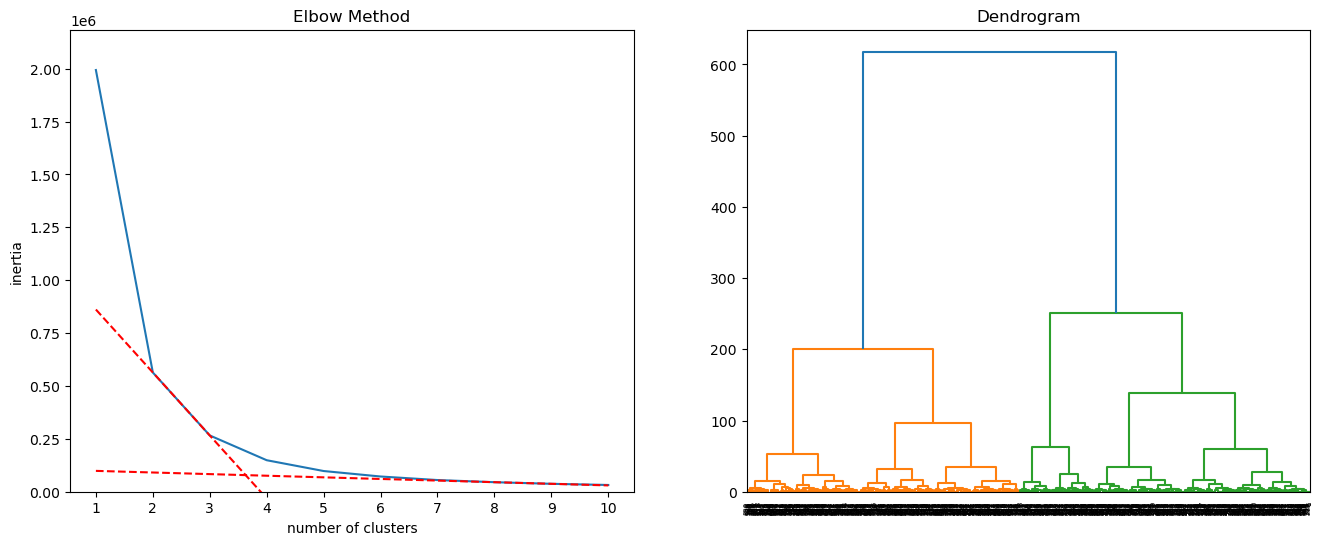

In [43]:
plot_clustering_methods(demographic, 10)

In [44]:
fit_kmeans_centroids(demographic, 3)

C:\Users\saras\AppData\Local\Temp\ipykernel_15696\1036560146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = model.labels_


label,0,1,2
Age,27.895087,67.486393,47.394656
Gender_Male,0.505828,0.506185,0.502672
Number of Dependents,0.536636,0.287976,0.545802
Married,0.490841,0.486888,0.472901


In [52]:
df["Cluster_demographic"] = demographic.label
demographic.groupby(["Cluster_demographic"]).describe().transpose()

KeyError: 'Cluster_demographic'

## 3.2. Service Usage Clustering
- Segmenting customers based on the services they use can provide insights into cross-selling or upselling opportunities. 
- For instance, if a particular cluster is high on phone services but low on online security, there might be an opportunity to pitch online security to them.

Features: 
- Phone Service
- Internet Service
- Online Security
- Online Backup
- Multiple Lines
- Device Protection Plan
- Premium Tech Support
- Unlimited Data
- Internet Type_Cable
- Internet Type_DSL
- Internet Type_Fiber Optic

## 3.3. Streaming Behavior Clustering
- This will help understand entertainment and content preferences of the customers, which can be used for partnerships with content providers or tailor-made package offers.

## 3.4. Customer Tenure & Contract Clustering 

- Understanding the commitment level and longevity of customers can be crucial for retention strategies. For instance, customers on a month-to-month contract with low tenure might be at a higher risk of churn.

## 3.5. Payment Behavior Clustering
- This can give insights into the financial habits of the customers. It might also give an indication of the trust level customers have with the company.

## 3.5. Profitability & Revenue Clustering
- Categorizing customers based on their revenue contribution can help in identifying high-value customers to offer special packages or loyalty benefits. It also helps in risk management to ensure high-value customers don't churn.

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#006400'> 
    
# 4. Churn Cluster analysis </font>
</a>
    
</div>

## 4.1. Churn Risk Clustering
- Clustering based on churn predictors can help in targeted retention strategies.

Features: 
- Churn Label
- Churn Score
- Churn Category_Attitude
- Churn Category_Competitor
- Churn Category_Dissatisfaction
- Churn Category_Price
- Satisfaction Score